# Define PANORAMIC fields

The associations have been computed and the preprocessing executed elsewhere....


In [3]:
import os
os.chdir('../Mosaics')

In [5]:
! cat panoramic_fields.txt

# field        n   sx    sy   ra         dec         nx  ny  date       time
j090000p0207  80   4.0   6.5 135.004000    2.114070  3   5  2023-04-03 09:42:05.050
j093144p0819 120   4.7   6.7 142.941000    8.325030  4   5  2023-04-20 04:53:11.366
j093452p6116  80   5.9   6.5 143.708500   61.272400  5   5  2023-04-06 19:16:17.682
j094232p0923 120   4.9   6.7 145.630000    9.378995  4   5  2023-04-19 09:41:11.366
j100736p2109  60   5.2   6.7 151.906000   21.155250  4   5  2023-05-07 07:21:18.312
j123800p6217 430  17.0  15.7 189.485500   62.249400 13  12  2023-03-28 07:25:57.468
j125652p5652 240   6.4   3.8 194.211500   56.865700  5   3  2023-04-01 19:15:23.999
j145652p2444  40   5.3   6.7 224.223500   24.740000  4   5  2023-03-24 02:33:18.312
j150604p5409 160   6.5   7.1 226.514500   54.154800  5   6  2023-04-03 14:28:49.893
j153500p2325 240   3.6   6.4 233.742500   23.420000  3   5  2023-03-06 09:39:23.999
j170720p5853 120   4.9   6.9 256.841500   58.879350  4   6  2023-02-18 00:03:56.209

In [6]:
# Which mosaics hae been made?
! cat mosaic_log.txt

# field  version date time
j090000p0207  v6.0  2023-05-04 09:44:57.191
j145652p2444  v6.0  2023-05-04 10:37:56.604
j093144p0819  v6.0  2023-05-04 11:16:46.528
j100736p2109  v6.0  2023-05-10 16:07:03.162
j093452p6116  v6.0  2023-05-10 18:43:31.732
j125652p5652  v6.0  2023-05-10 18:44:39.470
j150604p5409  v6.0  2023-05-10 19:45:12.123
j170720p5853  v6.0  2023-05-10 20:00:33.283
j094232p0923  v6.0  2023-05-10 20:12:52.988
j153500p2325  v6.0  2023-05-10 22:13:33.482


In [11]:
import os
import gc
import glob

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.time

from grizli.aws import db, visit_processor
from grizli import utils, prep
from grizli.pipeline import auto_script

from mastquery import overlaps

In [12]:
def create_s3_index(path, output_file="index.html", extra_html="", upload=True):
    """
    Create HTML listing of an S3 path
    """
    import time

    url = path.replace('s3://', 'https://s3.amazonaws.com/')

    lsfile = output_file.replace('.html','.ls')

    # Sort by filename
    sort_str = 'sort -k 4'

    os.system(f'aws s3 ls {path} | {sort_str} |grep -v PRE |grep -v {output_file} > {lsfile}')

    now = time.ctime()
    html=f"<h3>{now}</h3>\n"

    html += extra_html

    html += "\n<pre>\n"
    
    lines=open(lsfile).readlines()
    for line in lines:
        lsp = line.split()
        if len(lsp) == 4:
            html += "{0} {1} {2:>10} <a href={4}{3} > {3} </a>\n".format(*lsp, url)

    html += '</pre>\n'
    fp = open(output_file,'w')
    fp.write(html)
    fp.close()
    
    if upload:
        os.system(f'aws s3 cp {output_file} {path} --acl public-read')
        print(path.replace('s3://', 'https://s3.amazonaws.com/') + output_file)

    print(output_file)


## Query database for exposure footprints

In [13]:
# Query the grizli database for processed exposures
program_id = 2514 # Panoramic

res = db.SQL(f"""select assoc, dataset, filter,
crval1 as ra, crval2 as dec, footprint as coords,
expstart as t_min, exptime, detector, instrume
from exposure_files where (dataset like 'jw{program_id:05d}%%')
""")

len(res)


1692

In [14]:
# Group by "parent" defined when associations were generated
res['parent'] = [a.split('_')[0] for a in res['assoc']]
res['parent-filt'] = [a.split('_')[0] + '-' + f
                      for a, f in zip(res['assoc'], res['filter'])]
                      
un = utils.Unique(res['parent'])

   N  value     
====  ==========
  40  j145652p2444
  60  j100736p2109
  80  j090000p0207
  80  j093452p6116
 120  j093144p0819
 120  j094232p0923
 120  j170720p5853
 160  j150604p5409
 240  j125652p5652
 240  j153500p2325
 432  j123800p6217


# field        n   sx    sy   ra         dec         nx  ny  date       time
j090000p0207  80   4.0   6.5 135.004000    2.114070  3   5  2023-04-03 09:42:05.050
j093144p0819 120   4.7   6.7 142.941000    8.325030  4   5  2023-04-20 04:53:11.366
j093452p6116  80   5.9   6.5 143.708500   61.272400  5   5  2023-04-06 19:16:17.682
j094232p0923 120   4.9   6.7 145.630000    9.378995  4   5  2023-04-19 09:41:11.366
j100736p2109  60   5.2   6.7 151.906000   21.155250  4   5  2023-05-07 07:21:18.312
j123800p6217 432  17.0  15.7 189.485500   62.249400 13  12  2023-03-28 07:25:57.468
j125652p5652 240   6.4   3.8 194.211500   56.865700  5   3  2023-04-01 19:15:23.999
j145652p2444  40   5.3   6.7 224.223500   24.740000  4   5  2023-03-24 02:33:18.312
j150604p5409 160   6.5   7.1 226.514500   54.154800  5   6  2023-04-03 14:28:49.893
j153500p2325 240   3.6   6.4 233.742500   23.420000  3   5  2023-03-06 09:39:23.999
j170720p5853 120   4.9   6.9 256.841500   58.879350  4   6  2023-02-18 00:03:56.209

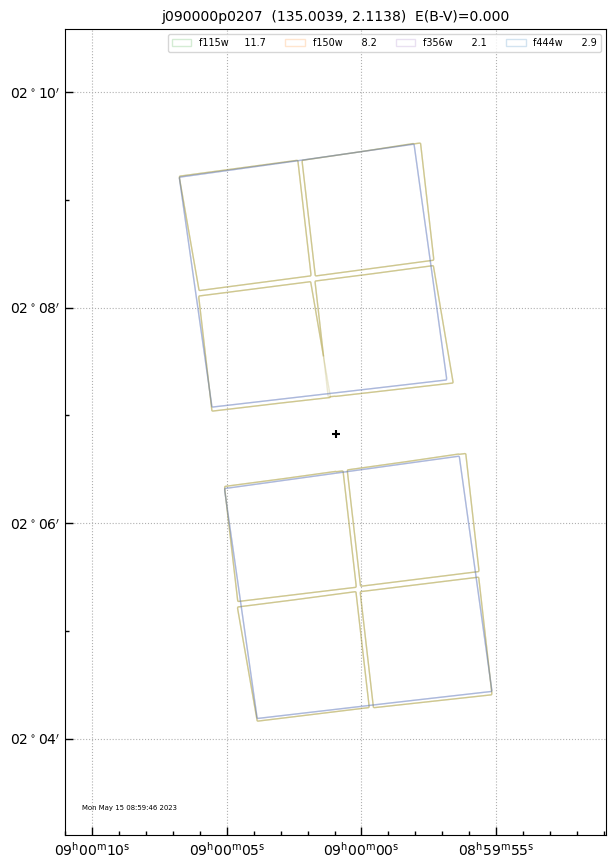

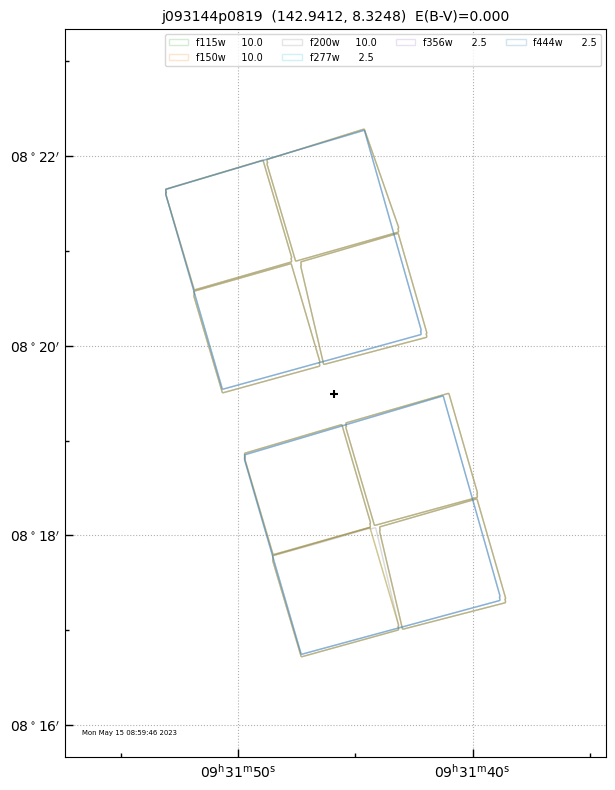

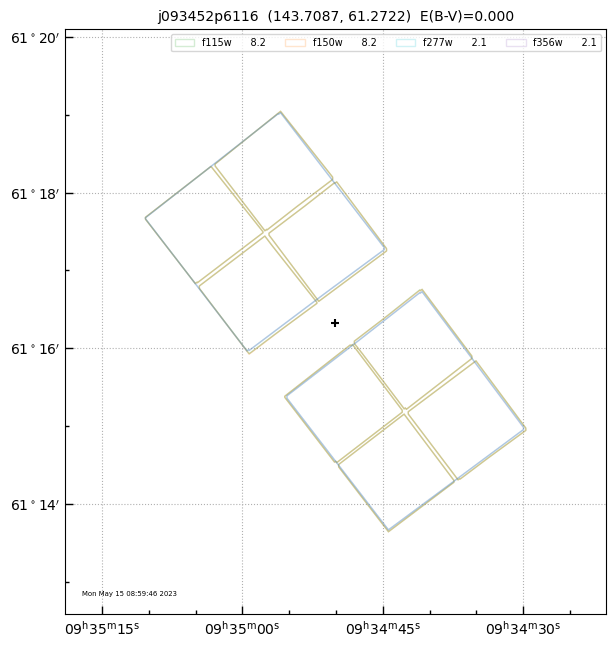

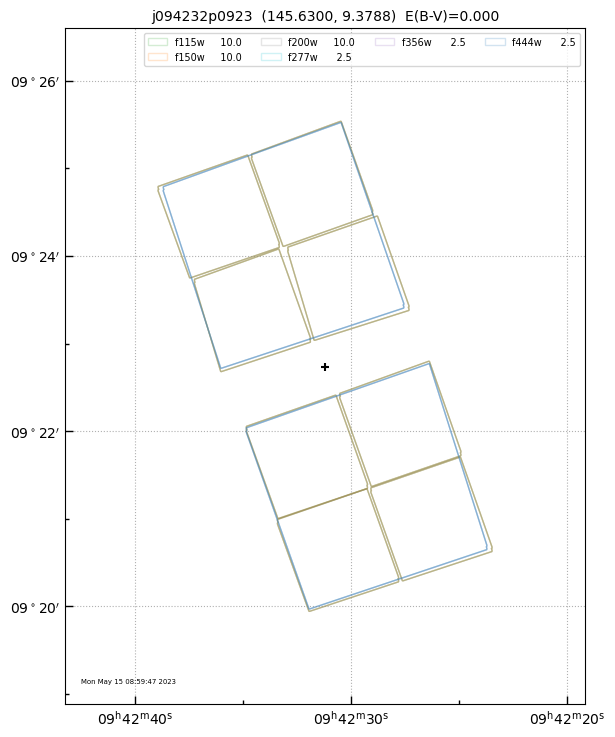

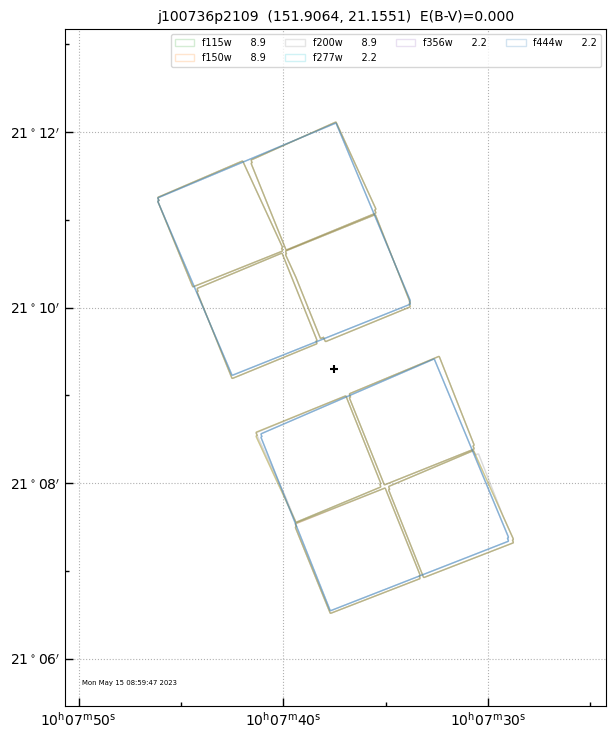

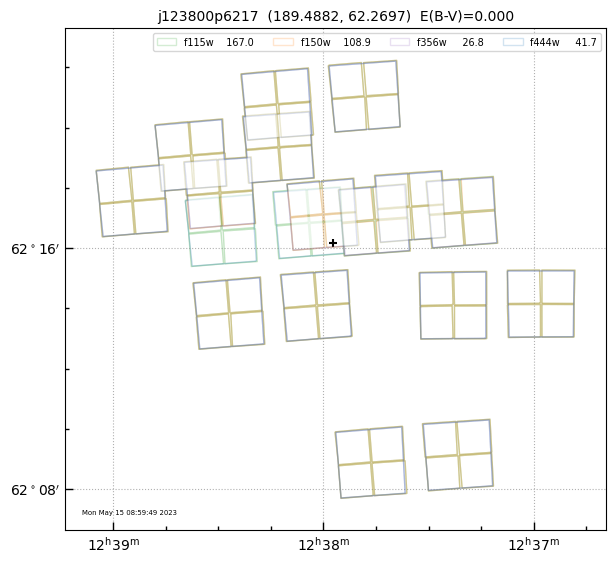

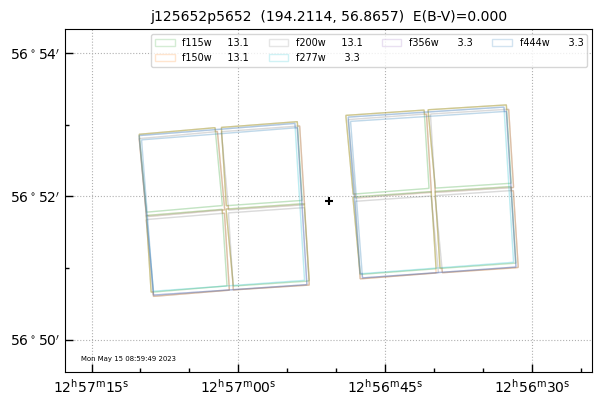

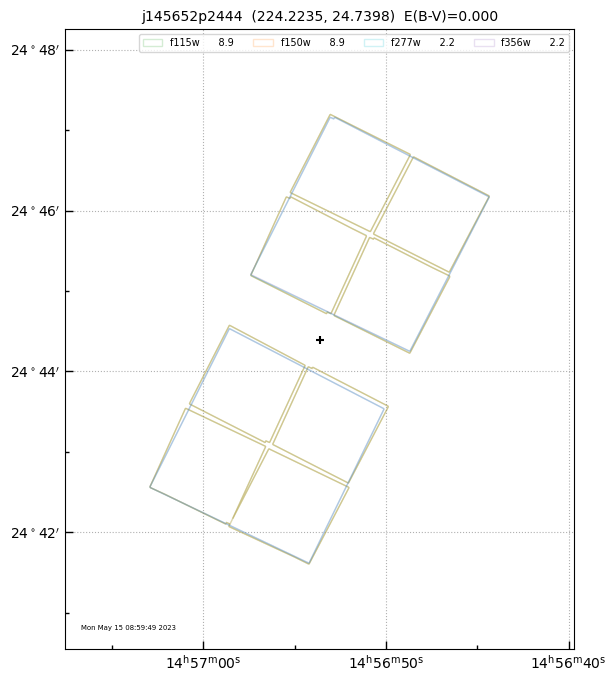

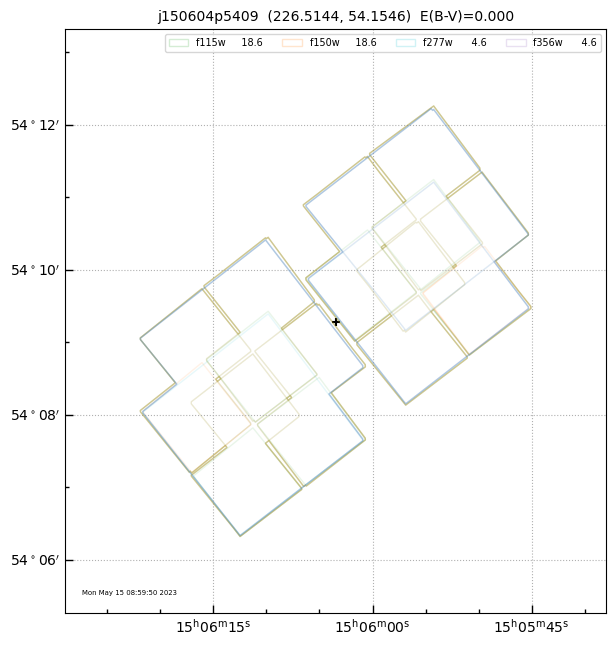

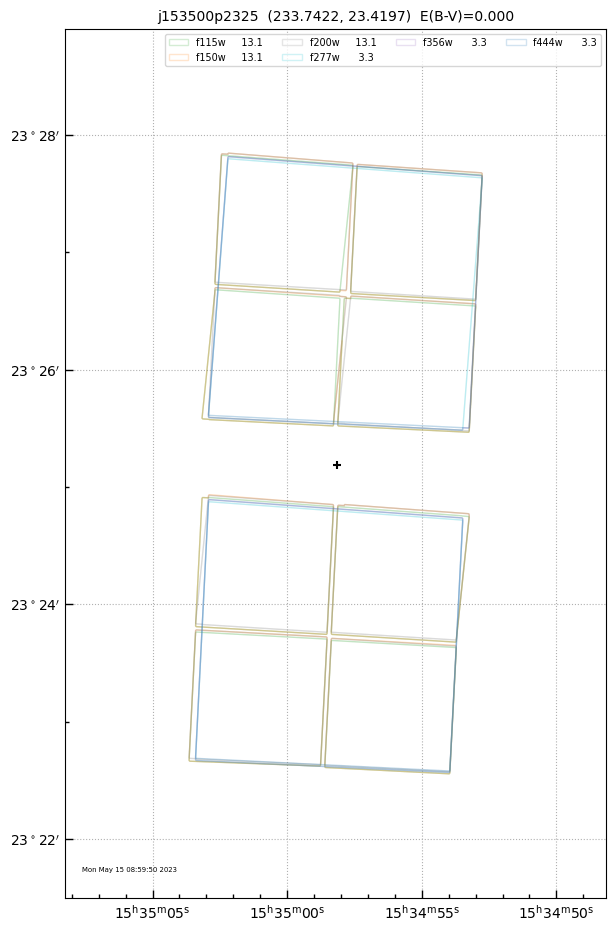

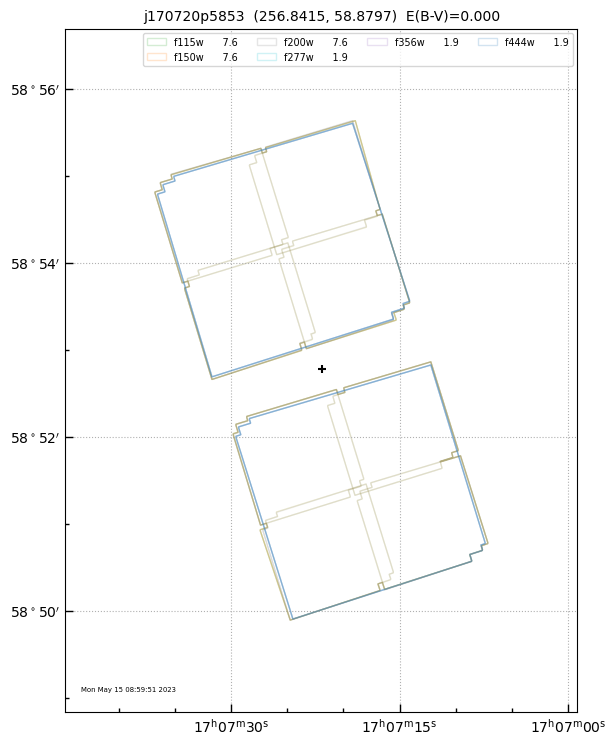

In [15]:
row = '# field        n   sx    sy   ra         dec         nx  ny  date       time'
with open('panoramic_fields.txt','w') as fp:
    fp.write(row+'\n')

print(row)

for field in un.values:
    rf = res[un[field]]
    
    # Things needed for the plot script
    rf.meta['NAME'] = field
    rf.meta['RA'] = np.mean(rf['ra'])
    rf.meta['DEC'] = np.mean(rf['dec'])
    rf.meta['MW_EBV'] = 0.0
    
    rf['obs_id'] = rf['dataset']
    rf['proposal_id'] = [int(d[3:7]) for d in rf['dataset']]
    rf['t_max'] = rf['t_min'] + rf['exptime']/86400.
    rf['instrument_name'] = rf['instrume']
    rf['target'] = 'indef'
    rf['filter'] = [f.split('-')[0] for f in rf['filter']]
    rf['footprint'] = [f'POLYGON {f.replace("(","").replace(")","").replace(","," ")}'
                       for f in rf['coords']]

    _ = overlaps.split_associations(rf, assoc_min=0, 
                                        #assoc_args=assoc_args,
                                        force_split=True,
                                        with_ls_thumbnail=False,
                                        xsize=6,
                                        )
                                        #ls_args=LS_ARGS)
    
    tab = _[0]
    fig = _[1]
    fig.savefig(f'panoramic-{field}.png')
    
    # size: the plot window is a box containing the exposures padded by 1arcmin
    cosd = np.cos(rf.meta['DEC']/180*np.pi)
    sx = (rf.meta['XMAX'] - rf.meta['XMIN'])*cosd*60-1
    sy = (rf.meta['YMAX'] - rf.meta['YMIN'])*60-1
    
    # Center of the plot as center ra/dec
    ra0 = (rf.meta['XMAX'] + rf.meta['XMIN'])/2.
    de0 = (rf.meta['YMAX'] + rf.meta['YMIN'])/2.
    
    # Size in units of 2048 x 40mas/pixel 
    nx = int(np.ceil(sx/(2048*0.04/60)))
    ny = int(np.ceil(sy/(2048*0.04/60)))

    tmax = astropy.time.Time(rf['t_max'].max(), format='mjd').iso

    row = f"{field:12} {un[field].sum():>3} {sx:5.1f} {sy:5.1f} {ra0:10.6f}  {de0:10.6f} {nx:>2}  {ny:>2}  {tmax}"
    with open('panoramic_fields.txt','a') as fp:
        fp.write(row+'\n')

    print(row)

## Run mosaics, catalogs

In [16]:
# Set version

mosaic_version = 'v6.0' # latest grizli (May 2023)

In [17]:
# Work in /scratch on the root filesystem if expect to make more than 5 GB of files.
# NB: files here won't be saved when the machine is shut down!

# hmm, but doesn't seem to work
if 0:
    work_path = '/scratch'
    if not os.path.exists(work_path):
        os.makedirs(work_path)
elif os.path.exists('/workspaces/panoramic-jwst'):
    work_path = '/workspaces/panoramic-jwst/Mosaics'
else:
    work_path = '/work'

os.chdir(work_path)
print(f'Working directory: {work_path}')

! df -h . 

FileNotFoundError: [Errno 2] No such file or directory: '/work'

In [18]:
fields = utils.read_catalog('panoramic_fields.txt')
fields.to_pandas()

,field,n,sx,sy,ra,dec,nx,ny,date,time
0,j090000p0207,80,4.0,6.5,135.0040,2.114070,3,5,2023-04-03,09:42:05.050
1,j093144p0819,120,4.7,6.7,142.9410,8.325030,4,5,2023-04-20,04:53:11.366
2,j093452p6116,80,5.9,6.5,143.7085,61.272400,5,5,2023-04-06,19:16:17.682
3,j094232p0923,120,4.9,6.7,145.6300,9.378995,4,5,2023-04-19,09:41:11.366
4,j100736p2109,60,5.2,6.7,151.9060,21.155250,4,5,2023-05-07,07:21:18.312
5,j123800p6217,432,17.0,15.7,189.4855,62.249400,13,12,2023-03-28,07:25:57.468
6,j125652p5652,240,6.4,3.8,194.2115,56.865700,5,3,2023-04-01,19:15:23.999
7,j145652p2444,40,5.3,6.7,224.2235,24.740000,4,5,2023-03-24,02:33:18.312
8,j150604p5409,160,6.5,7.1,226.5145,54.154800,5,6,2023-04-03,14:28:49.893
9,j153500p2325,240,3.6,6.4,233.7425,23.420000,3,5,2023-03-06,09:39:23.999


In [12]:
field_to_run = 'j153500p2325'

In [13]:
# Make a mosaic

LW_FILTERS = ['F277W-CLEAR','F356W-CLEAR','F444W-CLEAR',
              'F335M-CLEAR','F410M-CLEAR','F460M-CLEAR','F480M-CLEAR']

SW_FILTERS = ['F070W-CLEAR','F090W-CLEAR', 'F115W-CLEAR',
              'F150W-CLEAR','F200W-CLEAR', 'F210M-CLEAR' ]

WFC3IR_FILTERS = ['F160W','F140W','F125W','F110W','F105W','F098M']

ACS_FILTERS = ['F850LP','F814W','F606W','F435W','F438W','F775W']

for field in [field_to_run]:

    ix = np.where(fields['field'] == field)[0][0]

    pixel_scale = 0.04 # arcsec/pix

    hdu = utils.make_wcsheader(fields['ra'][ix], fields['dec'][ix],
                               size=(fields['nx'][ix]*2048*pixel_scale,
                                     fields['ny'][ix]*2048*pixel_scale),
                               pixscale=0.04, get_hdu=True)

    
    ir_wcs = pywcs.WCS(hdu.header)
    
    # Pull files from AWS and drizzle into a mosaic
    # NB: this will pull *any* exposure that overlaps with the defined WCS, 
    #     not just PANORAMIC from the query above. 

    root = f'panoramic-{field}-{mosaic_version}'
    for filt in LW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=False,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )
        gc.collect()
        # ! gzip {root}*{filt.lower()}*fits

    # SW run in a slightly weird way for memory issues?
    for filt in SW_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=True,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )
        gc.collect()
        ! gzip {root}*{filt.lower()}*fits

    # HST at 40mas, just in case
    for filt in WFC3IR_FILTERS + ACS_FILTERS:
        _ = visit_processor.cutout_mosaic(rootname=root,
                                      ir_wcs=ir_wcs,
                                      clean_flt=True,
                                      filters=[filt],
                                      half_optical=False,
                                      s3output=None,
                                      pixfrac=0.75,
                                      kernel='square',
                                      skip_existing=True,
                                      )


Skip panoramic-j153500p2325-v6.0-f277w-clear
Skip panoramic-j153500p2325-v6.0-f356w-clear
Skip panoramic-j153500p2325-v6.0-f444w-clear
No exposures found overlapping output wcs with corners = (233.705292,23.363112), (233.779708,23.476879)
No exposures found overlapping output wcs with corners = (233.705292,23.363112), (233.779708,23.476879)
No exposures found overlapping output wcs with corners = (233.705292,23.363112), (233.779708,23.476879)
No exposures found overlapping output wcs with corners = (233.705292,23.363112), (233.779708,23.476879)
No exposures found overlapping output wcs with corners = (233.705292,23.363112), (233.779708,23.476879)
gzip: panoramic-j153500p2325-v6.0*f070w-clear*fits: No such file or directory
No exposures found overlapping output wcs with corners = (233.705292,23.363112), (233.779708,23.476879)
gzip: panoramic-j153500p2325-v6.0*f090w-clear*fits: No such file or directory
Skip panoramic-j153500p2325-v6.0-f115w-clear
gzip: panoramic-j153500p2325-v6.0*f115w-

### RGB image

In [14]:
# RGB mosaic
def make_rgb(root, full_dimensions=2, scl=2.0):
    """
    Make RGB image
    """

    files = glob.glob(f"{root}*-f*clear*sci.fits*")
    files.sort()    

    filters = [f.split('-')[-2] + '-clear' for f in files]
    filters.sort()
    print(filters)

    auto_script.IMSAVE_QUALITY = 99

    norm = {'stretch': 'asinh', 'min_cut': -0.01, 
                                            'max_cut': 5.0, 'clip':True, 
                                            'asinh_a':0.010}

    im = pyfits.open(files[-1])

    msk = im[0].data != 0
    yp , xp = np.indices(msk.shape)
    spad = 64
    xyslice = (slice(np.maximum(xp[msk].min()-spad, 0), xp[msk].max()+spad), 
                slice(np.maximum(yp[msk].min()-spad, 0), yp[msk].max()+spad))

    print('slice: ', xyslice)

    filts = ['f356w-clear','f150w-clear','f115w-clear']
    rgb_scl = [1.0, 0.95, 1.02]

    if 'f444w-clear' in filters:
        filts = ['f444w-clear','f277w-clear','f115w-clear']

    rgb = auto_script.field_rgb(root,
                            HOME_PATH=None, gzext='*', 
                            filters=filts,
                            force_rgb=filts,
                            rgb_scl=rgb_scl,
                            full_dimensions=full_dimensions,
                            scl=scl,
                            suffix='.rgb',
                            xsize=128,
                            xyslice=xyslice,
                            add_labels=False,
                            norm_kwargs=norm,
                            output_format='png',
                            fill_black=True,
                            pl=2.0, pf=1)

    plt.close('all')    

In [15]:
if False: # Not enough memory on GitHub/codespace
    if (not os.path.exists(f'{root}.rgb.png')):
        make_rgb(root, full_dimensions=2, scl=2.0)
    else:
        print('RGB image found')
else:
    print('Not making RGB images....')


Not making RGB images....


### Detection image and catalog

LW detection image weighted by constant Fnu

Photometric catalog tends to run out of disk space...


In [16]:
from grizli.pipeline import auto_script
from grizli import prep
import astropy.io.fits as pyfits

comb = {'ir':['F444W-CLEAR','F356W-CLEAR','F277W-CLEAR',
              'F430M-CLEAR','F460M-CLEAR','F480M-CLEAR', 
              'CLEARP-F277W','CLEARP-F356W', 'CLEARP-F444W']}

block_filters = ['F090W-CLEAR','F115W-CLEAR','F150W-CLEAR','F200W-CLEAR']

# Not enough memory on GitHub/codespace?
MAKE_CATALOG = False

for field in fields['field']:
    root = f'panoramic-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue
    
    if len(glob.glob(f'{root}-ir_drc_sci.fits*')) == 0:
        status = auto_script.make_filter_combinations(root,
                                                  filter_combinations=comb, 
                                                  weight_fnu=2, 
                                                  force_photfnu=1.e-8,
                                                  block_filters=block_filters
                                                 )
    
    # Make the photometric catalog
    phot_apertures = prep.SEXTRACTOR_PHOT_APERTURES_ARCSEC[:4]
    
    # Skip catalogs for now, since they make "bkg" images that fill up the disk quota
    if (not os.path.exists(f'{root}_phot.fits')) & MAKE_CATALOG:
        try:
            auto_script.multiband_catalog(field_root=root, 
                                      threshold=1.2, 
                                      bkg_params={'bw': 50, 'bh': 50,
                                                  'fw': 3, 'fh': 3,
                                                  'pixel_scale': pixel_scale}, 
                                      get_all_filters=True,
                                      phot_err_scale=1.0, 
                                      phot_apertures=phot_apertures,
                                      )
    
            phot = utils.read_catalog(f'{root}_phot.fits')
        except OSError:
            pass

        ! rm {root}*bkg.fits
        ! gzip {root}*seg.fits

### Sync to S3

In [17]:
import astropy.time

for field in fields['field']:
    root = f'panoramic-{field}-{mosaic_version}'

    files = glob.glob(f'{root}*sci.fits*')
    if len(files) == 0:
        continue

    # Upload to S3
    ! rm {root}*bkg.fits

    files = glob.glob(f'{root}*_dr*fits')
    files += glob.glob(f'{root}*seg.fits')
    files.sort()
    
    for file in files:
        print(f'gzip {file}')
        ! gzip {file}

    s3path = f's3://grizli-panoramic/mosaics/{mosaic_version}/{field}/'

    ! aws s3 sync ./ {s3path} --exclude "*" --include "{root}*gz" --include "{root}*csv" --include "{root}*phot.fits" --include "{root}*cat.fits" --include "*{field}*png" --acl public-read

    extra_html = f"<img src=panoramic-{field}.png height=400px> <img src={root}.rgb.png height=400px> \n<br>"

    filter_files = glob.glob(f'{root}*fp.png')
    filter_files.sort()
    for file in filter_files:
        extra_html += f"<img src={file} height=200px>\n"

    extra_html += "<pre>\n# filter  expstart  ndrizim  exptime\n"
    files = glob.glob(f'{root}-f*_dr*sci.fits.gz')
    files.sort()
    for file in files:
        with pyfits.open(file) as im:
            expfact = 1.
            if im[0].header['INSTRUME'] == 'NIRCAM':
                if im[0].header['DETECTOR'] in ['NRCALONG','NRCBLONG']:
                    expfact = 2
                else:
                    expfact = 8

            row = f"{im[0].header['FILTER']} {im[0].header['EXPSTART']:.2f}  {im[0].header['NDRIZIM']//expfact}  {im[0].header['EXPTIME']/expfact:.1f}"

            print(row)
            extra_html += row + '\n'

    extra_html += f"</pre>\n"

    create_s3_index(s3path, output_file="index.html", extra_html=extra_html, upload=True)
    
    # Add to log
    log = utils.read_catalog('mosaic_log.txt')
    done = (log['field'] == field) & (log['version'] == mosaic_version)
    if done.sum() == 0:
        print(f'Add {field} {mosaic_version} to log.')

        with open('mosaic_log.txt','a') as fp:
            fp.write(f'{field}  {mosaic_version}  {astropy.time.Time.now().iso}\n')
    


gzip panoramic-j153500p2325-v6.0-f277w-clear_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-f277w-clear_drc_wht.fits
gzip panoramic-j153500p2325-v6.0-f356w-clear_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-f356w-clear_drc_wht.fits
gzip panoramic-j153500p2325-v6.0-f444w-clear_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-f444w-clear_drc_wht.fits
gzip panoramic-j153500p2325-v6.0-ir_drc_sci.fits
gzip panoramic-j153500p2325-v6.0-ir_drc_wht.fits
gzip panoramic-j153500p2325-v6.0-ir_seg.fits
upload: ./panoramic-j153500p2325-v6.0-f115w-clear_fp.png to s3://grizli-panoramic/mosaics/v6.0/j153500p2325/panoramic-j153500p2325-v6.0-f115w-clear_fp.png
upload: ./panoramic-j153500p2325-v6.0-f115w-clear_wcs.csv to s3://grizli-panoramic/mosaics/v6.0/j153500p2325/panoramic-j153500p2325-v6.0-f115w-clear_wcs.csv
upload: ./panoramic-j153500p2325-v6.0-f150w-clear_fp.png to s3://grizli-panoramic/mosaics/v6.0/j153500p2325/panoramic-j153500p2325-v6.0-f150w-clear_fp.png
upload: ./panoramic-j153500p2325-v6.0-f150

## Master HTML log for all processed mosaics

Don't delete `mosaic_log.txt` if clearing out files to make space!

In [18]:
! cat mosaic_log.txt

# field  version date time
j090000p0207  v6.0  2023-05-04 09:44:57.191
j145652p2444  v6.0  2023-05-04 10:37:56.604
j093144p0819  v6.0  2023-05-04 11:16:46.528
j100736p2109  v6.0  2023-05-10 16:07:03.162
j093452p6116  v6.0  2023-05-10 18:43:31.732
j125652p5652  v6.0  2023-05-10 18:44:39.470
j150604p5409  v6.0  2023-05-10 19:45:12.123
j170720p5853  v6.0  2023-05-10 20:00:33.283
j094232p0923  v6.0  2023-05-10 20:12:52.988
j153500p2325  v6.0  2023-05-10 22:13:33.482


In [19]:

log = utils.read_catalog('mosaic_log.txt')

un = utils.Unique(log['version'])

with open('mosaics.html','w') as fp:
    for v in un.values:
        fp.write(f'<h3> Version {v} </h3>\n')

        for i in np.where(un[v])[0]:
            s3 = f"https://s3.amazonaws.com/grizli-panoramic/mosaics/{v}/{log['field'][i]}/index.html"
            fp.write(f"{log['date'][i]} {log['time'][i]} <a href=\"{s3}\" /> {log['field'][i]} </a> <br> \n")

    fp.write(f'<h3> Fields </h3>\n')
    for field in fields['field']:
        fp.write(f'<p> {field} </p> <img src=panoramic-{field}.png height=300px /> \n')

! aws s3 sync ./ s3://grizli-panoramic/mosaics/ --exclude "*" --include "mosaics.html" --include "panoramic*png" --exclude "*fp.png" --acl public-read



   N  value     
====  ==========
  10  v6.0      
upload: ./mosaics.html to s3://grizli-panoramic/mosaics/mosaics.html
upload: ./panoramic-j153500p2325.png to s3://grizli-panoramic/mosaics/panoramic-j153500p2325.png
upload: ./panoramic-j090000p0207.png to s3://grizli-panoramic/mosaics/panoramic-j090000p0207.png
upload: ./panoramic-j093452p6116.png to s3://grizli-panoramic/mosaics/panoramic-j093452p6116.png
upload: ./panoramic-j093144p0819.png to s3://grizli-panoramic/mosaics/panoramic-j093144p0819.png
upload: ./panoramic-j123800p6217.png to s3://grizli-panoramic/mosaics/panoramic-j123800p6217.png
upload: ./panoramic-j145652p2444.png to s3://grizli-panoramic/mosaics/panoramic-j145652p2444.png
upload: ./panoramic-j094232p0923.png to s3://grizli-panoramic/mosaics/panoramic-j094232p0923.png
upload: ./panoramic-j150604p5409.png to s3://grizli-panoramic/mosaics/panoramic-j150604p5409.png
upload: ./panoramic-j100736p2109.png to s3://grizli-panoramic/mosaics/panoramic-j100736p2109.png
upload:

In [20]:
!df -h . 

Filesystem      Size  Used Avail Use% Mounted on
/dev/loop0       32G   17G   14G  55% /workspaces


## Cleanup

In [21]:
! rm panoramic*fits* panoramic*fp.png panoramic*wcs.csv panoramic*rgb.png

rm: cannot remove 'panoramic*rgb.png': No such file or directory


# Tiling on S3

Define field tiles for the interactive FitsMap webpages

In [319]:
tile_fields = db.SQL("""select field, AVG(crval1) as ra, AVG(crval2) as dec, count(field) from combined_tiles
group by field
order by field
""")
tile_fields

field,ra,dec,count
str22,float64,float64,int64
abell2744,3.58750000,-30.39666670,225
cos,150.12500000,2.20000000,1089
dracoii,238.19833330,64.56528000,64
egs,214.82880000,52.80673330,484
egs-v2,214.82880000,52.80673330,484
gdn,189.23690290,62.23128390,289
gds,53.15924640,-27.78282230,289
j013804m2156,24.51616000,-21.93046000,225
...,...,...,...


In [320]:
field_footprints = db.SQL("""select field, tile, footprint from combined_tiles""")
len(field_footprints)

7310

In [321]:
fields = utils.read_catalog('panoramic_fields.txt')
fields['parent'] = fields['field']

so = np.argsort(fields['date'])

# Shift by half tile to put one NIRCam module in the center of a tile
xsh = 3.072/60./2.

fields['ra'] -= xsh/np.cos(fields['dec']/180*np.pi)
fields['dec'] -= xsh

fields[so]

field,n,sx,sy,ra,dec,nx,ny,date,time,parent
str12,int64,float64,float64,float64,float64,int64,int64,str10,str12,str12
j170720p5853,120,4.9,6.9,256.7919684123834,58.853750000000005,4,6,2023-02-18,00:03:56.209,j170720p5853
j153500p2325,240,3.6,6.4,233.71460161799536,23.3944,3,5,2023-03-06,09:39:23.999,j153500p2325
j145652p2444,40,5.3,6.7,224.19531287984384,24.714399999999998,4,5,2023-03-24,02:33:18.312,j145652p2444
j123800p6217,432,17.0,15.7,189.43051999110227,62.223800000000004,13,12,2023-03-28,07:25:57.468,j123800p6217
j125652p5652,240,6.4,3.8,194.1646653081678,56.8401,5,3,2023-04-01,19:15:23.999,j125652p5652
j090000p0207,80,4.0,6.5,134.97838256387973,2.08847,3,5,2023-04-03,09:42:05.050,j090000p0207
j150604p5409,160,6.5,7.1,226.47078395384054,54.129200000000004,5,6,2023-04-03,14:28:49.893,j150604p5409
j093452p6116,80,5.9,6.5,143.65523834493206,61.2468,5,5,2023-04-06,19:16:17.682,j093452p6116
j094232p0923,120,4.9,6.7,145.6040531416622,9.353394999999999,4,5,2023-04-19,09:41:11.366,j094232p0923


In [323]:
# Look if panoramic fields already have tiles
coo = np.array([fields['ra'], fields['dec']]).T

fields['field'] = [f'panoramic-{f}' for f in fields['parent']]

fields['in_tile'] = False
for fi, fp in zip(field_footprints['field'], field_footprints['footprint']):
    sr = utils.SRegion(fp)
    in_i = sr.path[0].contains_points(coo)
    fields['field'][in_i] = fi
    fields['in_tile'] |= in_i
    
# Default 46 arcmin on a size to be big and to match
# center tile default of (9,9) in grizli.field_tiles.process_tile
fields['dx'] = fields['dy'] = 46
fields['rsize'] = fields['dx']/2

In [324]:
fields[so]

field,n,sx,sy,ra,dec,nx,ny,date,time,parent,in_tile,dx,dy,rsize
str22,int64,float64,float64,float64,float64,int64,int64,str10,str12,str12,bool,int64,int64,float64
panoramic-j170720p5853,120,4.9,6.9,256.7919684123834,58.853750000000005,4,6,2023-02-18,00:03:56.209,j170720p5853,True,46,46,23.0
panoramic-j153500p2325,240,3.6,6.4,233.71460161799536,23.3944,3,5,2023-03-06,09:39:23.999,j153500p2325,True,46,46,23.0
panoramic-j145652p2444,40,5.3,6.7,224.19531287984384,24.714399999999998,4,5,2023-03-24,02:33:18.312,j145652p2444,True,46,46,23.0
gdn,432,17.0,15.7,189.43051999110227,62.223800000000004,13,12,2023-03-28,07:25:57.468,j123800p6217,True,46,46,23.0
panoramic-j125652p5652,240,6.4,3.8,194.1646653081678,56.8401,5,3,2023-04-01,19:15:23.999,j125652p5652,True,46,46,23.0
panoramic-j090000p0207,80,4.0,6.5,134.97838256387973,2.08847,3,5,2023-04-03,09:42:05.050,j090000p0207,True,46,46,23.0
panoramic-j150604p5409,160,6.5,7.1,226.47078395384054,54.129200000000004,5,6,2023-04-03,14:28:49.893,j150604p5409,True,46,46,23.0
panoramic-j093452p6116,80,5.9,6.5,143.65523834493206,61.2468,5,5,2023-04-06,19:16:17.682,j093452p6116,True,46,46,23.0
panoramic-j094232p0923,120,4.9,6.7,145.6040531416622,9.353394999999999,4,5,2023-04-19,09:41:11.366,j094232p0923,True,46,46,23.0


In [325]:
from grizli.aws.field_tiles import make_field_tiles

ix = -1
tiles = make_field_tiles(**fields[ix], tile_npix=2048+256, pscale=0.08, initial_status=90, send_to_database=False)

# CRPIX1, CRPIX2 should be 1152,1152 for tile '09.09'
ii = tiles['tile'] == '09.09'
tiles[ii]

panoramic-j170720p5853: tile size, arcmin = 3.072


tile,wcsaxes,crpix1,crpix2,cd1_1,cd2_2,cdelt1,cdelt2,cunit1,cunit2,ctype1,ctype2,crval1,crval2,lonpole,latpole,mjdref,radesys,naxis,naxis1,naxis2,footprint,status,field
str5,int64,float64,float64,float64,float64,float64,float64,str3,str3,str8,str8,float64,float64,float64,float64,float64,str4,int64,int64,int64,str93,int64,str22
09.09,2,1152.0,1152.0,-2.2222222222222e-05,2.2222222222222e-05,1.0,1.0,deg,deg,RA---TAN,DEC--TAN,256.79196841238,58.85375,180.0,58.85375,0.0,ICRS,2,2304,2304,"((256.841405,58.828152),(256.841478,58.879329),(256.742458,58.879329),(256.742531,58.828152))",90,panoramic-j170720p5853


# Send to database

In [327]:
# if 0:
#     db.execute("delete from combined_tiles where field like 'panoramic%%'")

In [328]:
for ix in so: #range(len(fields)):
    if not fields['in_tile'][ix]:
        print(ix, fields[ix]['field'])
        tiles = make_field_tiles(**fields[ix], tile_npix=2048+256, pscale=0.08, initial_status=90, send_to_database=True)
    else:
        print(f"{ix:>3}: Tile field {fields['field'][ix]} found")

 10: Tile field panoramic-j170720p5853 found
  9: Tile field panoramic-j153500p2325 found
  7: Tile field panoramic-j145652p2444 found
  5: Tile field gdn found
  6: Tile field panoramic-j125652p5652 found
  0: Tile field panoramic-j090000p0207 found
  8: Tile field panoramic-j150604p5409 found
  2: Tile field panoramic-j093452p6116 found
  3: Tile field panoramic-j094232p0923 found
  1: Tile field panoramic-j093144p0819 found
  4: Tile field panoramic-j100736p2109 found


# Generate drizzled tiles on EC2

This still in another notebook ....

## Make map HTML

Make the webpages for the FITSMap tile viewer

In [346]:
field = 'panoramic-j100736p2109'
# field = 'panoramic-j150604p5409'
# field = 'panoramic-j094232p0923'

# field = 'panoramic-j090000p0207'
# field = 'panoramic-j093144p0819'
# field = 'panoramic-j093452p6116'
# field = 'panoramic-j094232p0923'
# field = 'panoramic-j125652p5652'
# field = 'panoramic-j145652p2444'
# field = 'panoramic-j153500p2325'
# field = 'panoramic-j170720p5853'

html_file = f'{field}_map.html'

fix = np.where(fields['field'] == field)[0][0]

f_tiles = db.SQL(f"""select * from combined_tiles_filters where field = '{field}'""")
un = utils.Unique(f_tiles['filter'])

   N  value     
====  ==========
   8  F115W-CLEAR
   8  F150W-CLEAR
   8  F200W-CLEAR
   8  F277W-CLEAR
   8  F356W-CLEAR
   8  F444W-CLEAR


In [347]:
HEAD = """<!DOCTYPE html>
<html>
<head>
   <title>FitsMap</title>
   <meta charset="utf-8" />
   <meta name="viewport" content="width=device-width, initial-scale=1.0">
   <link rel="shortcut icon" type="image/x-icon" href="docs/images/favicon.ico" />
   <link rel="stylesheet" href="https://unpkg.com/leaflet@1.3.4/dist/leaflet.css" integrity="sha512-puBpdR0798OZvTTbP4A8Ix/l+A4dHDD0DGqYW6RQ+9jxkRFclaxxQb/SJAWZfWAkuyeQUytO7+7N4QKrDh+drA==" crossorigin=""/>

   <script src='https://unpkg.com/leaflet@1.3.4/dist/leaflet.js' integrity='sha512-nMMmRyTVoLYqjP9hrbed9S+FzjZHW5gY1TWCHA5ckwXZBadntCNs8kEqAWdrb9O7rxbCaA4lKTIWjDXZxflOcA==' crossorigin=''></script>
   <script type='text/javascript' src='https://code.jquery.com/jquery-3.6.0.slim.min.js' charset='utf-8'></script>
"""

HEAD += f"""
<script src='{field}_tiles.js'> </script>
<script src='{field}_vizier.js'> </script>
"""

HEAD += """
   <style>
       html, body {
       height: 100%;
       margin: 0;
       }
       #map {
           width: 100%;
           height: 100%;
       }
       
       .leaflet-popup-content-wrapper {
           width: 530px;
       }
       .leaflet-popup-content {
           width: 520px;
       }
       
       #query {
           position: fixed;
           bottom: 0px;
           left: 0px;
           padding: 2px 2px 2px 2px;
           margin: 0;
           font-size: 8pt;
           font-family: Verdana;
           color: #333;
           z-index: 1000;
           background: #fff;
           background: rgba(255, 255, 255, 0.7);
       }
       
       #query a:link {
           text-decoration: none;
           color: #0078A8;
       }
       
       #query a:hover {
           text-decoration: underline;
           color: #0078A8;
       }

       input {
           font-size: 8pt;
       }
       
       #coordbox {
           position: fixed;
           bottom: 16px;
           left: 0px;
           padding: 2px 2px 2px 2px;
           margin: 0;
           font-size: 8pt;
           font-family: Verdana;
           color: #333;
           z-index: 1000;
           background: #fff;
           background: rgba(255, 255, 255, 0.7);
       }
       
   </style>
</head>
<body>
   <div id="map"></div>
   <div id="coordbox"> <input type="text" placeholder="RA Dec" id="boxtext" class="input" onkeydown="panFromBox(map)"/> </div>
   <div id="query"> - | - | - </div>
   
   <script>
    L.CRS.FitsMap = L.extend({}, L.CRS.Simple, {
        transformation: new L.Transformation(1/16, 0, -1/16, 256)
    });
    
    // var overlays = {}; // initialized in tiles.js
    """

FOOTER = f"""
    var layerControl = L.control.layers(baseLayers, overlays);

    // WCS parameters
    // {field}
    var crpix = [1152.0, 1152.0]; 
    var crval = [{fields['ra'][fix]}, {fields['dec'][fix]}]; 
    var cdmatrix = [[-2.222222e-05, 0.000000e+00],
                    [0.000000e+00, 2.222222e-05]];
"""

FOOTER += """
    var map = L.map("map", {
        crs: L.CRS.FitsMap,
        zoom: 2,
        minZoom: 0,
        preferCanvas: true,
"""

FOOTER += f"""layers: {field.replace('-','_').lower()}_080_ncrgb,"""

FOOTER += """
    });
    layerControl.addTo(map);
    
    var markers = null;

    urlParam = function(name){
        // Parse parameters from window.location, 
        // e.g., .../index.html?zoom=8
        // urlParam(zoom) = 8
        var results = new RegExp('[\?&]' + name + '=([^&#]*)').exec(window.location.href);
        if (results==null){
           return null;
        }
        else{
           return decodeURI(results[1]) || 0;
        }
    }

    pixToSky = function(xy){
        // Convert from zero-index pixel to sky coordinate assuming 
        // simple North-up WCS
        if (xy.hasOwnProperty('lng')){
            var dx = xy.lng - crpix[0] + 1;
            var dy = xy.lat - crpix[1] + 1;        
        } else {
            var dx = xy[0] - crpix[0] + 1;
            var dy = xy[1] - crpix[1] + 1;
        }
        var dra = dx * cdmatrix[0][0];
        var ddec = dy * cdmatrix[1][1];
        var ra = crval[0] + dra / Math.cos(crval[1]/180*3.14159);
        var dec = crval[1] + ddec;
        return [ra, dec];
    }

    skyToPix = function(rd){
        // Convert from sky to zero-index pixel coordinate assuming 
        // simple North-up WCS
        var dx = (rd[0] - crval[0]) * Math.cos(crval[1]/180*3.14159);
        var dy = (rd[1] - crval[1]);
        var x = crpix[0] - 1 + dx / cdmatrix[0][0];
        var y = crpix[1] - 1 + dy / cdmatrix[1][1];
        return [x,y];
    }

    skyToLatLng = function(rd){
        // Convert from sky to Leaflet.latLng coordinate assuming 
        // simple North-up WCS    
        var xy = skyToPix(rd);
        return L.latLng(xy[1], xy[0]);
    }

    setZoomFromUrl = function(map){
        // Read "zoom" from url bar
        var zoom = urlParam('zoom');
        if (zoom !== null){
            // console.log("zoom to " + zoom);
            map.setZoom(zoom);
        } else {
            map.setZoom(3);
        }
    }
    
    panToSky = function(rd, map){
        // Pan map to celestial coordinates
        var ll = skyToLatLng(rd)
        map.panTo(ll, map.getZoom());
        // console.log("pan to: " + rd + " / ll: " + ll.lng + ',' + ll.lat);
    }

    parseCoord = function(rd, hours) {
        // Parse sexagesimal coordinates if ':' found in rd
        if (rd.includes(':')){
            var dms = rd.split(':')
            
            var deg = dms[0]*1; 
            if (deg < 0) {
                var sign = -1;
            } else {
                var sign = 1;
            }
            deg += sign*dms[1]/60. + sign*dms[2]/3600.;
            if (hours > 0) {
                deg *= 360/24.
            }
        } else {
            var deg = rd;
        }
        return deg
    }

    panFromUrl = function(map){
        // Pan map based on ra/dec/[zoom] variables in location bar
        var ra = urlParam('ra');
        var dec = urlParam('dec');
        var coord = urlParam('coord');
        var coords = urlParam('coords');
        
        if ((ra !== null) & (dec !== null)) {
            panToSky([parseCoord(ra, 1), parseCoord(dec, 0)], map);
        } else if ((coord !== null)) {
            var rd = coord.split(',');
            if ((rd.length == 1)) {
                rd = coord.split(' ');
            }
            // console.log(rd);
            panToSky([parseCoord(rd[0], 1), parseCoord(rd[1], 0)], map)
        } else if ((coords !== null)) {
            var rd = coords.split(',');
            if ((rd.length == 1)) {
                rd = coords.split(' ');
            }
            // console.log(rd);
            panToSky([parseCoord(rd[0], 1), parseCoord(rd[1], 0)], map)
        } else {
            // Pan to crval
            panToSky(crval, map);
        }
        setZoomFromUrl(map);
    }
    
    panFromBox = function(map){
        // Pan map based on ra/dec/[zoom] variables in location bar
        var coord = $('#boxtext').val();
        var rd = coord.split(',');
        if ((rd.length == 1)) {
            rd = coord.split(' ');
        }
        panToSky([parseCoord(rd[0], 1), parseCoord(rd[1], 0)], map);
    }
    
    updateLocationBar = function(){
        var rd = pixToSky(map.getCenter());
        var params = 'coord=' + rd[0].toFixed(7);
        params += ',' + rd[1].toFixed(7);
        params += '&zoom=' + map.getZoom();
        var param_url = window.location.href.split('?')[0] + '?' + params;
        window.history.pushState('', '', param_url);

        // Query bar
        var legacyurl = 'https://www.legacysurvey.org/viewer?layer=ls-dr9&zoom=17';
        legacyurl += '&ra=' + rd[0].toFixed(7);
        legacyurl += '&dec=' + rd[1].toFixed(7);
        
        var query_html = '<a href="'+legacyurl+'">LegacySurvey</a>';
        
        var cdsurl = 'http://vizier.u-strasbg.fr/viz-bin/VizieR?&-c.rs=1&-c=';
        cdsurl += rd[0].toFixed(7);
        cdsurl += ',' + rd[1].toFixed(7);
        query_html += ' | <a href="'+cdsurl+'">CDS</a>';
        
        var esourl = 'https://archive.eso.org/scienceportal/home?pos=';
        esourl += rd[0].toFixed(7);
        esourl += ',' + rd[1].toFixed(7);
        esourl += '&r=0.02&dp_type=IMAGE,CUBE';
        query_html += ' | <a href="'+esourl+'">ESO</a>';
        
        var mfspectra = 'https://grizli-cutout.herokuapp.com/mosfire?mode=table&sep=5';
        mfspectra += '&ra=' + rd[0].toFixed(7);
        mfspectra += '&dec=' + rd[1].toFixed(7);
        query_html += ' | <a href="'+mfspectra+'">MOSFIRE</a>';
        
        var cutout = 'https://grizli-cutout.herokuapp.com/thumb?all_filters=True&size=4&scl=1.0&asinh=True&filters=f814w,f115w-clear,f277w-clear,f444w-clear&rgb_scl=1.5,0.74,1.3&pl=2';
        cutout += '&ra=' + rd[0].toFixed(7);
        cutout += '&dec=' + rd[1].toFixed(7);
        query_html += ' | <a href="'+cutout+'">NIRCam</a>';
"""

all_filters = ','.join([v.lower() for v in un.values])
if 'f814w' not in all_filters:
    all_filters = 'f814w,' + all_filters

FOOTER += f"""
        var cut2 = 'https://grizli-cutout.herokuapp.com/thumb?all_filters=True&size=4&scl=1.0&asinh=False&filters={all_filters}&rgb_scl=1.3,0.9,1.3&pl=2';
        cut2 += '&ra=' + rd[0].toFixed(7);
        cut2 += '&dec=' + rd[1].toFixed(7);
        query_html += ' | <a href="'+cut2+'">All filters</a>';
"""

FOOTER += """
        // var miricut = 'https://grizli-cutout.herokuapp.com/thumb?all_filters=True&size=4&scl=1&asinh=True&filters=f150w-clear,f444w-clear,f770w&rgb_scl=0.8,1.2,1.0&pl=2.0';
        // miricut += '&ra=' + rd[0].toFixed(7);
        // miricut += '&dec=' + rd[1].toFixed(7);
        // query_html += ' | <a href="'+miricut+'">NRC+MIR</a>';

        $('#query').html(query_html);
    }
    
    clearOverlays = function(){
        if (markers !== null){
            for(i = 0; i < markers.length; i++) {
                overlays[labels[i]].remove();
                console.log('clear overlays: ' + labels[i])
            }
        }
    }

    $( document ).ready(function() {    
        // Set pan from URL bar, if ra/dec/zoom specified
        panFromUrl(map);
        
        // Clear any catalog overlays
        clearOverlays();
        
        // Event handlers to update location bar when view changes
        map.on('moveend', updateLocationBar);
        map.on('zoomend', updateLocationBar);

    });    
    
   </script>
</body>
</html>
"""


In [348]:
f_low = field.replace('-','_').lower()

with open(html_file,'w') as fp:
    fp.write(HEAD)
    
    field_filters = un.values + ['swrgb','lwrgb','ncrgb']
    
    for f in field_filters:
        fi = f.lower()
        line = f"""var {f_low}_080_{fi.split('-clear')[0]} =  L.tileLayer("{f_low}_080_{fi}"""
        line += """/{z}/{y}/{x}.png",{ attribution:"<a href='https://github.com/ryanhausen/fitsmap'>FitsMap</a>", minZoom: 0, maxZoom: 9, minNativeZoom: 1, maxNativeZoom: 4,});"""
        fp.write(line + '\n')
    
    fp.write("""
    var baseLayers = {\n""")
    
    for f in field_filters:
        fi = f.lower()
        fp.write(f"""        "{f}": {f_low}_080_{fi.split('-clear')[0]},\n""")
    
    fp.write("    };\n")
    
    fp.write(FOOTER)
    
! aws s3 cp {html_file} s3://grizli-v2/ClusterTiles/Map/{field}/index.html --acl public-read
print(f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/{field}/index.html")


upload: ./panoramic-j100736p2109_map.html to s3://grizli-v2/ClusterTiles/Map/panoramic-j100736p2109/index.html
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j100736p2109/index.html


## Tile overlay

Make a javascript overlay with links to the tile FITS files.

In [349]:
tiles = db.SQL(f"""select c.field, c.tile, c.filter, t.footprint from combined_tiles_filters c, combined_tiles t
where (c.field = t.field) AND (c.tile = t.tile) AND c.field = '{field}'
""")

ref_tile = db.SQL(f"""select * from combined_tiles where field = '{field}' AND tile = '09.09'""")

h = pyfits.Header()
for k in ref_tile.colnames:
    h[k[:8]] = ref_tile[k][0]
    
wcs = pywcs.WCS(h)

key = ['{field}-080-{tile}'.format(**row) for row in tiles]
un = utils.Unique(key, verbose=False)
ix = un.unique_index()

lix = un.list_indices

with open(f'{field}_tiles.js','w') as fp:
    fp.write('var overlays = {};\nvar tiles = [];\n')
    
    for i, (v, f) in enumerate(zip(un.values, tiles['footprint'][ix])):
        filters = tiles['filter'][lix[i]].tolist()
        
        so = np.argsort(filters)
        filters = [filters[i] for i in so]
        
        print(v, ' '.join(filters))
        
        sr = utils.SRegion(f)
        xy = wcs.all_world2pix(*sr.xy[0].T, 0)
        xyl = np.array(xy[::-1]).T.tolist()
        xyls = ','.join(['[{0:.1f},{1:.1f}]'.format(*r) for r in xyl])
        
        tt = f"""bindTooltip('{v}', {{ direction: 'auto'}})"""
        path = f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/{field}"
        pop = f"bindPopup('<h3> Tile {v.split('-')[-1]} </h3> "
        for f in filters:
            if f in ['F110W','F125W','F140W','F160W','F770W','F1800W']:
                file = f'{v}-{f.lower()}_drz_sci.fits.gz'
            else:
                file = f'{v}-{f.lower()}_drc_sci.fits.gz'
            
            pop += f'<a href="{path}/{file}" /> {file} </a> '
            pop += f"/ <a href=\"{path}/{file.replace('sci','wht')}\" /> wht </a> <br>"

        color = 'white'
        
        if 'F444W-CLEAR' in filters:
            color = 'cornsilk'
        if 'F770W' in filters:
            color = 'crimson'
            
        pop += "')"
        fp.write(f"""tiles.push(L.polygon([ {xyls} ], {{color: '{color}', weight:2, opacity:0.2, fill:true}}).{tt}.{pop});\n""")

        # if i > 5:
        #     break
    
    fp.write("overlays['FITS tiles'] = L.layerGroup(tiles);")
    
! aws s3 cp {field}_tiles.js s3://grizli-v2/ClusterTiles/Map/{field}/ --acl public-read


panoramic-j100736p2109-080-08.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-08.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-08.10 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-08.11 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-09.08 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-09.09 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-09.10 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
panoramic-j100736p2109-080-09.11 F115W-CLEAR F150W-CLEAR F200W-CLEAR F277W-CLEAR F356W-CLEAR F444W-CLEAR
upload: ./panoramic-j100736p2109_tiles.js to s3://grizli-v2/ClusterTiles/Map/panoramic-j100736p2109/panoramic-j100736p2109_tiles.js


## Vizier catalogs

Make a JavaScript overlay with some Vizier queries

In [350]:
# Vizier catalogs
viz_catalogs = {'DESI-N (Duncan+22)':('VII/292/north','olive'),
                'DESI-S (Duncan+22)':('VII/292/south','olive'),
                'GAIA DR3': ('I/355/gaiadr3', 'lightblue'),
                #'Chandra (Evans+2019)': ('IX/57/csc2master', 'pink'), # Doesn't work?
               }

In [351]:
from grizli import utils
import grizli.catalog
import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from matplotlib.colors import to_hex

v = 'J/A+A/602/A1/table1'

! rm {field}_vizier.js

has_catalog = []

for vname in viz_catalogs:
    if (vname == 'DESI-S (Duncan+22)') & ('DESI-N (Duncan+22)' in has_catalog):
        print('Skip ', vname)
        continue

    v, vcolor = viz_catalogs[vname]
    
    vcat = grizli.catalog.query_tap_catalog(ra=fields['ra'][fix], dec=fields['dec'][fix],
                   radius=10, vizier=True,
                   db=f'"{v}"', verbose=False)
    
    print(vname, v, len(vcat))
    if len(vcat) == 0:
        continue
    
    has_catalog.append(vname)
        
    cm = plt.cm.summer
    
    if 'zphot' in vcat.colnames:
        vcat['comment'] = ['id = {id} <br> z<sub>phot</sub> = {zphot:.2f}'.format(vname=vname, **row) for row in vcat]
    elif 'DR3Name' in vcat.colnames:
        vcat['comment'] = ['{DR3Name} <br> pm = {pmRA:.2f}, {pmDE:.2f} mas'.format(**row) for row in vcat]
    elif '2CXO' in vcat.colnames:
        vcat['comment'] = ['Chandra Source Catalog <br> 2CXO = {2CXO}'.format(**row) for row in vcat]
    else:
        vcat['comment'] = vname
        
    #col = cm(np.clip((vcat['SNR']-5)/8, 0,1)*0.7+0.2)
    
    key = vname.split()[0].replace('-','_').lower()
    
    with open(f'{field}_vizier.js','a') as fp:
        fp.write(f'var {key} = [];\n')

        olay = []
        si = 0.5/0.1 # R=0.5"
        col = vcolor
        
        for ri, di, comment in zip(vcat['ra'], vcat['dec'], vcat['comment']):
            sr = utils.SRegion(f'CIRCLE({ri},{di},{si}")', wrap=False, ncircle=16)
            xy = wcs.all_world2pix(*sr.xy[0].T, 0)
            xyl = np.array(xy[::-1]).T.tolist()
            xyls = ','.join(['[{0:.1f},{1:.1f}]'.format(*r) for r in xyl])

            xpi, ypi = wcs.all_world2pix([ri], [di], 0)

            # olay.append(f'[{xyls}]')

            # fp.write(f"""vla3.push(L.polygon([ {xyls} ], {{color: '{to_hex(ci)}', weight:2, opacity:0.8, fill:false}}).bindTooltip('VLA 3GHz {sid} - {flux:.1f} uJy', {{ direction: 'auto'}}));\n""")
            fp.write(f"""{key}.push(L.circleMarker([{ypi[0]:.1f},{xpi[0]:.1f}], {{radius:8,color:'{col}',weight:2,opacity:0.8,fill:false}}).bindTooltip('{comment}', {{direction:'auto'}}));\n""")

        fp.write(f"""overlays['{vname}'] = L.layerGroup({key});""")
    
    ! aws s3 cp {field}_vizier.js s3://grizli-v2/ClusterTiles/Map/{field}/ --acl public-read

print(f"https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/{field}/index.html")


DESI-N (Duncan+22) VII/292/north 2125
upload: ./panoramic-j100736p2109_vizier.js to s3://grizli-v2/ClusterTiles/Map/panoramic-j100736p2109/panoramic-j100736p2109_vizier.js
Skip  DESI-S (Duncan+22)


2023-05-15 15:47:16,897 - stpipe - WARNING - /var/folders/dw/fyp140x977s3y5d2mdxw6m0w0000gn/T/ipykernel_10208/2953817009.py:35: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  vcat['comment'] = ['{DR3Name} <br> pm = {pmRA:.2f}, {pmDE:.2f} mas'.format(**row) for row in vcat]



GAIA DR3 I/355/gaiadr3 93
upload: ./panoramic-j100736p2109_vizier.js to s3://grizli-v2/ClusterTiles/Map/panoramic-j100736p2109/panoramic-j100736p2109_vizier.js
https://s3.amazonaws.com/grizli-v2/ClusterTiles/Map/panoramic-j100736p2109/index.html
